# Лабораторна робота #5

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

generator = torch.Generator().manual_seed(5921)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class MRIDataset(Dataset):
    def __init__(self , transform , root_dir , split = 'Training' ):
        self.root_dir = os.path.join(root_dir , split)
        self.categories = os.listdir(self.root_dir)
        self.transform = transform
        self.split = split
        self.data = self.load_data()
        
    def load_data(self):
        data = []
        for i , category in enumerate(self.categories):
            category_path = os.path.join(self.root_dir , category)
            for file_name in os.listdir(category_path):
                img_path = os.path.join(category_path , file_name)
                
                data.append([img_path , i])
        return data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self , idx):
        img_path , label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        label = torch.tensor(label)
        if self.transform:
            transformed_image = self.transform(image)
            
        return transformed_image.to(device) , label.to(device)

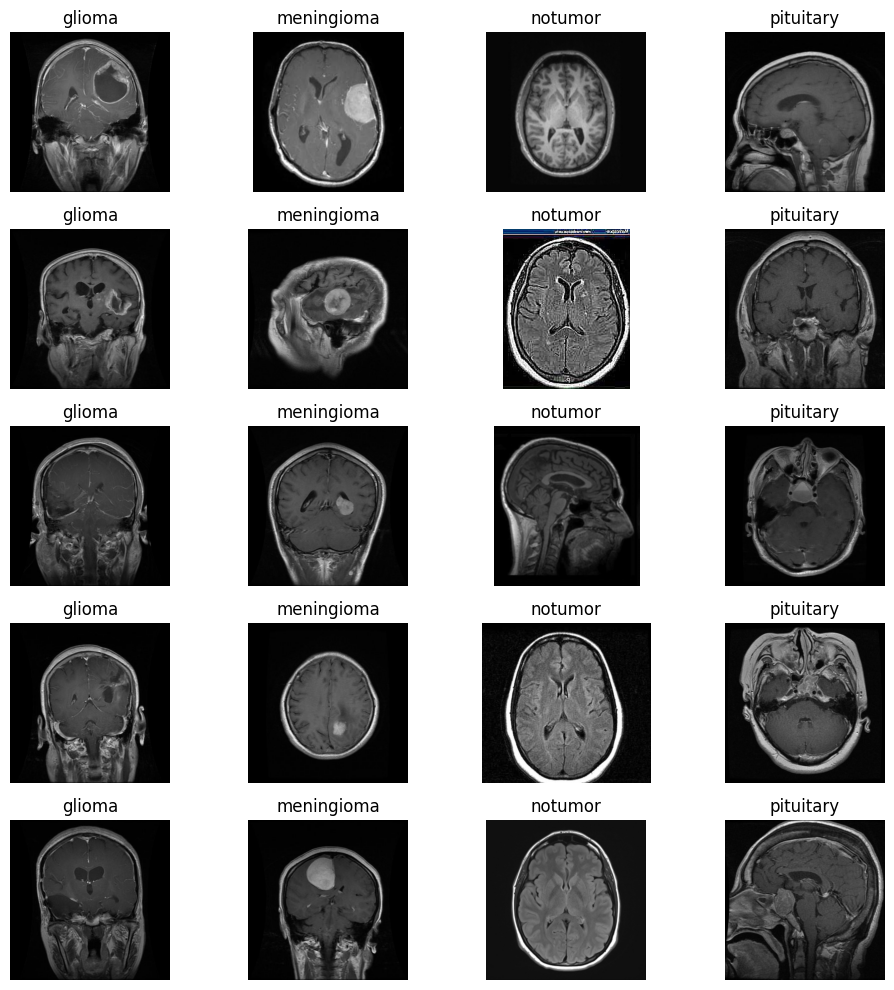

In [9]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ROOT_DIR = './brain-tumor-img/'

train_dataset = MRIDataset(transform , root_dir=ROOT_DIR, split='Training')
test_dataset = MRIDataset(transform , root_dir=ROOT_DIR, split='Testing')

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

fig , axes = plt.subplots(5,4, figsize = (10,10))
categories = os.listdir(os.path.join(ROOT_DIR, "Training"))
for i in range(len(categories)): 
    for j in range(5):
        category_path = os.path.join(os.path.join(ROOT_DIR, "Training"), categories[i])
        category_images = random.sample(os.listdir(category_path) , 1)[0]
        random_image = os.path.join(category_path , category_images )
        axes[j , i].imshow(Image.open(random_image).convert("RGB"))
        axes[j , i].set_title(categories[i])
        axes[j , i].set_axis_off()
        
plt.tight_layout()

In [10]:
class DoubleConvolution(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNetEncoder(nn.Module):
    def __init__(self, input_channels, output_channels, is_pooling):
        super().__init__()
        if is_pooling: 
            self.encode = nn.Sequential(
                DoubleConvolution(input_channels, output_channels),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        else:
            self.encode = DoubleConvolution(input_channels, output_channels)

    def forward(self, x):
        return self.encode(x)

class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upscale = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.decode = DoubleConvolution(in_channels, out_channels)
    
    def forward(self, x, x1):
        x = self.upscale(x)
        x1 = transforms.functional.center_crop(x1, output_size=[x.size(2), x.size(3)])
        x = torch.cat([x1, x], dim=1)
        return self.decode(x)

class UNetOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.output = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.output(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = DoubleConvolution(3, 64)
        self.e2 = UNetEncoder(64, 128, True)
        self.e3 = UNetEncoder(128, 256, True)
        self.e4 = UNetEncoder(256, 512, True)
        self.e5 = UNetEncoder(512, 1024, False)

        self.d1 = UNetDecoder(1024, 512)
        self.d2 = UNetDecoder(512, 256)
        self.d3 = UNetDecoder(256, 128)
        self.d4 = UNetDecoder(128, 64)

        self.out = UNetOutput(64, 4)

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(e1)  
        e3 = self.e3(e2)  
        e4 = self.e4(e3)  
        e5 = self.e5(e4)  

        d1 = self.d1(e5, e4)
        d2 = self.d2(d1, e3)
        d3 = self.d3(d2, e2)
        d4 = self.d4(d3, e1)

        return self.out(d4)


In [11]:
# Initialize the UNet model
model = UNet().to(device)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        print(outputs.shape, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs , 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs , 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')

torch.Size([4, 4, 448, 448]) tensor([2, 1, 2, 1], device='cuda:0')


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [4]